In [943]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Preprocessing

In [944]:
file_path = "../data/raw/Synthetic_Diseases_Dataset_1500.csv"
file_path2 = "../data/processed/Modified_Semi_Supervised_Dataset.csv"
#max rows displayed
pd.set_option('display.max_rows', None)
data=pd.read_csv(file_path)
data2=pd.read_csv(file_path2)

data.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure,Cholesterol Level,is_labeled
0,Asthma,No,Yes,No,No,34,Female,Normal,Low,1
1,Dengue Fever,No,No,No,No,68,Female,Normal,Normal,0
2,Eczema,No,No,No,Yes,90,Female,Normal,High,1
3,Dengue Fever,No,Yes,Yes,Yes,75,Female,High,High,0
4,Dengue Fever,Yes,Yes,Yes,No,83,Female,Low,Normal,0


In [945]:
# file_path = "../data/raw/Diseases_dataset.csv"
# #max rows displayed
# pd.set_option('display.max_rows', None)
# data=pd.read_csv(file_path)

# data.head()

In [946]:
data['is_labeled'] = 1 
unlabeled_percentage = 0.2

unlabeled_indices = np.random.choice(data.index, size=int(len(data) * unlabeled_percentage), replace=False)


data.loc[unlabeled_indices, 'Disease'] = np.nan

data.loc[unlabeled_indices, 'is_labeled'] = 0
# data=data.drop(columns=["Outcome Variable"])

print(data.head())  
modified_path = "../data/processed/Synthetic_Diseases_Dataset_1500.csv"
data.to_csv(modified_path, index=False)

        Disease Fever Cough Fatigue Difficulty Breathing  Age  Gender  \
0        Asthma    No   Yes      No                   No   34  Female   
1  Dengue Fever    No    No      No                   No   68  Female   
2        Eczema    No    No      No                  Yes   90  Female   
3           NaN    No   Yes     Yes                  Yes   75  Female   
4  Dengue Fever   Yes   Yes     Yes                   No   83  Female   

  Blood Pressure Cholesterol Level  is_labeled  
0         Normal               Low           1  
1         Normal            Normal           1  
2         Normal              High           1  
3           High              High           0  
4            Low            Normal           1  


In [947]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Disease               1200 non-null   object
 1   Fever                 1500 non-null   object
 2   Cough                 1500 non-null   object
 3   Fatigue               1500 non-null   object
 4   Difficulty Breathing  1500 non-null   object
 5   Age                   1500 non-null   int64 
 6   Gender                1500 non-null   object
 7   Blood Pressure        1500 non-null   object
 8   Cholesterol Level     1500 non-null   object
 9   is_labeled            1500 non-null   int64 
dtypes: int64(2), object(8)
memory usage: 117.3+ KB


In [948]:
file_path = "../data/processed/Synthetic_Diseases_Dataset_1500.csv"
data = pd.read_csv(file_path)

In [949]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
import joblib

# Step 1: Handle categorical columns with reversible encoding


# Ensure Disease column contains original disease names
all_disease_data = data['Disease'].dropna()  # Get only labeled data (non-NaN)
all_disease_data = all_disease_data.astype(str).unique()  # Get unique disease names

# Initialize and fit the LabelEncoder with actual disease names
disease_encoder = LabelEncoder()
disease_encoder.fit(all_disease_data)  # Fit on unique disease names

# Apply the encoding to labeled data
data['Disease'] = data['Disease'].astype(str)  # Convert to string for consistency
data.loc[data['Disease'] != 'nan', 'Disease'] = disease_encoder.transform(
    data.loc[data['Disease'] != 'nan', 'Disease']
).astype(float)

# Restore NaN for unlabeled rows
data['Disease'] = data['Disease'].replace('nan', np.nan)

# Save the encoder for later decoding
joblib.dump(disease_encoder, 'disease_encoder.pkl')

# Verify the mapping
print("Disease Encoder Classes:", disease_encoder.classes_)


# Encode 'Gender' using LabelEncoder
gender_encoder = LabelEncoder()
data['Gender'] = gender_encoder.fit_transform(data['Gender'])
joblib.dump(gender_encoder, 'gender_encoder.pkl')

# Encode binary categorical columns: 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing'
binary_columns = ['Fever', 'Cough', 'Fatigue', 'Difficulty Breathing']
for col in binary_columns:
    data[col] = data[col].map({'Yes': 1, 'No': 0})

# One-hot encode 'Blood Pressure' with a specific encoder
bp_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_bp = bp_encoder.fit_transform(data[['Blood Pressure']])
bp_columns = bp_encoder.get_feature_names_out(['Blood Pressure'])
bp_df = pd.DataFrame(encoded_bp, columns=bp_columns, index=data.index)
joblib.dump(bp_encoder, 'bp_encoder.pkl')  # Save the blood pressure encoder

# One-hot encode 'Cholesterol Level' with a separate encoder
cholesterol_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_cholesterol = cholesterol_encoder.fit_transform(data[['Cholesterol Level']])
cholesterol_columns = cholesterol_encoder.get_feature_names_out(['Cholesterol Level'])
cholesterol_df = pd.DataFrame(encoded_cholesterol, columns=cholesterol_columns, index=data.index)
joblib.dump(cholesterol_encoder, 'cholesterol_encoder.pkl')  # Save the cholesterol encoder

# Drop original columns and add one-hot encoded columns
data = pd.concat([data.drop(columns=['Blood Pressure', 'Cholesterol Level']), bp_df, cholesterol_df], axis=1)

# Step 2: Scale numerical columns
scaler = StandardScaler()
data['Age'] = scaler.fit_transform(data[['Age']])

# Save the scaler for later
joblib.dump(scaler, 'scaler.pkl')

# Step 3: Confirm preprocessing
print(data.head())


Disease Encoder Classes: ['Asthma' 'Common Cold' 'Dengue Fever' 'Eczema' 'Influenza']
   Disease  Fever  Cough  Fatigue  Difficulty Breathing       Age  Gender  \
0      0.0      0      1        0                     0 -0.530722       0   
1      2.0      0      0        0                     0  0.646352       0   
2      3.0      0      0        0                     1  1.407988       0   
3      NaN      0      1        1                     1  0.888691       0   
4      2.0      1      1        1                     0  1.165649       0   

   is_labeled  Blood Pressure_High  Blood Pressure_Low  Blood Pressure_Normal  \
0           1                  0.0                 0.0                    1.0   
1           1                  0.0                 0.0                    1.0   
2           1                  0.0                 0.0                    1.0   
3           0                  1.0                 0.0                    0.0   
4           1                  0.0            

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22992\1442796485.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Disease'] = data['Disease'].replace('nan', np.nan)


In [950]:
data.to_csv(modified_path, index=False)

Spliting the Dataset


In [951]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Disease                   1200 non-null   float64
 1   Fever                     1500 non-null   int64  
 2   Cough                     1500 non-null   int64  
 3   Fatigue                   1500 non-null   int64  
 4   Difficulty Breathing      1500 non-null   int64  
 5   Age                       1500 non-null   float64
 6   Gender                    1500 non-null   int64  
 7   is_labeled                1500 non-null   int64  
 8   Blood Pressure_High       1500 non-null   float64
 9   Blood Pressure_Low        1500 non-null   float64
 10  Blood Pressure_Normal     1500 non-null   float64
 11  Cholesterol Level_High    1500 non-null   float64
 12  Cholesterol Level_Low     1500 non-null   float64
 13  Cholesterol Level_Normal  1500 non-null   float64
dtypes: float

In [952]:
data.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,is_labeled,Blood Pressure_High,Blood Pressure_Low,Blood Pressure_Normal,Cholesterol Level_High,Cholesterol Level_Low,Cholesterol Level_Normal
0,0.0,0,1,0,0,-0.530722,0,1,0.0,0.0,1.0,0.0,1.0,0.0
1,2.0,0,0,0,0,0.646352,0,1,0.0,0.0,1.0,0.0,0.0,1.0
2,3.0,0,0,0,1,1.407988,0,1,0.0,0.0,1.0,1.0,0.0,0.0
3,NaN,0,1,1,1,0.888691,0,0,1.0,0.0,0.0,1.0,0.0,0.0
4,2.0,1,1,1,0,1.165649,0,1,0.0,1.0,0.0,0.0,0.0,1.0


In [953]:
# data

In [954]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Disease                   1200 non-null   float64
 1   Fever                     1500 non-null   int64  
 2   Cough                     1500 non-null   int64  
 3   Fatigue                   1500 non-null   int64  
 4   Difficulty Breathing      1500 non-null   int64  
 5   Age                       1500 non-null   float64
 6   Gender                    1500 non-null   int64  
 7   is_labeled                1500 non-null   int64  
 8   Blood Pressure_High       1500 non-null   float64
 9   Blood Pressure_Low        1500 non-null   float64
 10  Blood Pressure_Normal     1500 non-null   float64
 11  Cholesterol Level_High    1500 non-null   float64
 12  Cholesterol Level_Low     1500 non-null   float64
 13  Cholesterol Level_Normal  1500 non-null   float64
dtypes: float

In [955]:
data.info()
data.to_csv(modified_path, index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Disease                   1200 non-null   float64
 1   Fever                     1500 non-null   int64  
 2   Cough                     1500 non-null   int64  
 3   Fatigue                   1500 non-null   int64  
 4   Difficulty Breathing      1500 non-null   int64  
 5   Age                       1500 non-null   float64
 6   Gender                    1500 non-null   int64  
 7   is_labeled                1500 non-null   int64  
 8   Blood Pressure_High       1500 non-null   float64
 9   Blood Pressure_Low        1500 non-null   float64
 10  Blood Pressure_Normal     1500 non-null   float64
 11  Cholesterol Level_High    1500 non-null   float64
 12  Cholesterol Level_Low     1500 non-null   float64
 13  Cholesterol Level_Normal  1500 non-null   float64
dtypes: float

In [956]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Disease                   280 non-null    float64
 1   Fever                     349 non-null    int64  
 2   Cough                     349 non-null    int64  
 3   Fatigue                   349 non-null    int64  
 4   Difficulty Breathing      349 non-null    int64  
 5   Age                       349 non-null    float64
 6   Gender                    349 non-null    int64  
 7   is_labeled                349 non-null    int64  
 8   Blood Pressure_High       349 non-null    float64
 9   Blood Pressure_Low        349 non-null    float64
 10  Blood Pressure_Normal     349 non-null    float64
 11  Cholesterol Level_High    349 non-null    float64
 12  Cholesterol Level_Low     349 non-null    float64
 13  Cholesterol Level_Normal  349 non-null    float64
dtypes: float64

In [957]:
data2.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,is_labeled,Blood Pressure_High,Blood Pressure_Low,Blood Pressure_Normal,Cholesterol Level_High,Cholesterol Level_Low,Cholesterol Level_Normal
0,NaN,1,0,1,1,-2.091160,0,0,0.0,1.0,0.0,0.0,0.0,1.0
1,21.0,0,1,1,0,-1.631964,0,1,0.0,0.0,1.0,0.0,0.0,1.0
2,33.0,0,1,1,0,-1.631964,0,1,0.0,0.0,1.0,0.0,0.0,1.0
3,4.0,1,1,0,1,-1.631964,1,1,0.0,0.0,1.0,0.0,0.0,1.0
4,4.0,1,1,0,1,-1.631964,1,1,0.0,0.0,1.0,0.0,0.0,1.0


In [958]:
data.head()

,Disease,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,is_labeled,Blood Pressure_High,Blood Pressure_Low,Blood Pressure_Normal,Cholesterol Level_High,Cholesterol Level_Low,Cholesterol Level_Normal
0,0.0,0,1,0,0,-0.530722,0,1,0.0,0.0,1.0,0.0,1.0,0.0
1,2.0,0,0,0,0,0.646352,0,1,0.0,0.0,1.0,0.0,0.0,1.0
2,3.0,0,0,0,1,1.407988,0,1,0.0,0.0,1.0,1.0,0.0,0.0
3,NaN,0,1,1,1,0.888691,0,0,1.0,0.0,0.0,1.0,0.0,0.0
4,2.0,1,1,1,0,1.165649,0,1,0.0,1.0,0.0,0.0,0.0,1.0


Self-Training (Pseudo-Labeling)


In [959]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import joblib


# Step 2: Separate labeled and unlabeled data
labeled_data = data[data['is_labeled'] == 1]
unlabeled_data = data[data['is_labeled'] == 0]

# Ensure no NaN values in labeled data
labeled_data = labeled_data.dropna(subset=['Disease'])

# Separate features and target for labeled data
X_labeled = labeled_data.drop(columns=['Disease', 'is_labeled'])
y_labeled = labeled_data['Disease'].astype(float)  # Ensure it is float for consistency

# Prepare features for unlabeled data
X_unlabeled = unlabeled_data.drop(columns=['Disease', 'is_labeled'])

# Step 3: Train initial supervised model
model = RandomForestClassifier(random_state=42)
model.fit(X_labeled, y_labeled)

# Step 4: Self-training loop
max_iterations = 10
confidence_threshold = 0.9  # Confidence threshold for pseudo-labeling
iteration = 0

while iteration < max_iterations and len(X_unlabeled) > 0:
    # Generate pseudo-labels for unlabeled data
    pseudo_probabilities = model.predict_proba(X_unlabeled)
    pseudo_labels = model.predict(X_unlabeled)

    # Filter high-confidence predictions
    high_confidence_mask = np.max(pseudo_probabilities, axis=1) > confidence_threshold
    high_confidence_data = X_unlabeled[high_confidence_mask]
    high_confidence_labels = pseudo_labels[high_confidence_mask]

    if len(high_confidence_data) == 0:
        print(f"No high-confidence predictions in iteration {iteration}. Stopping self-training.")
        break

    # Add high-confidence pseudo-labeled data to the training set
    high_confidence_data = high_confidence_data.copy()  # Ensure DataFrame copy
    high_confidence_data['Disease'] = high_confidence_labels  # Add pseudo-labels
    labeled_data = pd.concat([labeled_data, high_confidence_data])

    # Update training data
    X_labeled = labeled_data.drop(columns=['Disease', 'is_labeled'])
    y_labeled = labeled_data['Disease']

    # Remove used high-confidence samples from the unlabeled data
    X_unlabeled = X_unlabeled[~high_confidence_mask]

    # Retrain the model
    model.fit(X_labeled, y_labeled)

    print(f"Iteration {iteration + 1}: Added {len(high_confidence_data)} pseudo-labeled samples.")
    iteration += 1

# Step 5: Evaluate the model on validation data
validation_data = data[data['is_labeled'] == 1]
X_val = validation_data.drop(columns=['Disease', 'is_labeled'])
y_val = validation_data['Disease'].astype(float)

# Ensure encoding matches original labels
y_val_encoded = y_val  # Already encoded using the unified encoder
y_val_pred = model.predict(X_val)

# Decode predictions for interpretability
decoded_predictions = disease_encoder.inverse_transform(y_val_pred.astype(int))
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print("Decoded Predictions:", decoded_predictions)


Iteration 1: Added 1 pseudo-labeled samples.
Iteration 2: Added 1 pseudo-labeled samples.
No high-confidence predictions in iteration 2. Stopping self-training.
Validation Accuracy: 0.985
Decoded Predictions: ['Asthma' 'Influenza' 'Common Cold' ... 'Dengue Fever' 'Asthma' 'Asthma']


In [960]:
X_labeled.head()

,Fever,Cough,Fatigue,Difficulty Breathing,Age,Gender,Blood Pressure_High,Blood Pressure_Low,Blood Pressure_Normal,Cholesterol Level_High,Cholesterol Level_Low,Cholesterol Level_Normal
0,0,1,0,0,-0.530722,0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,0,0,0,0.646352,0,0.0,0.0,1.0,0.0,0.0,1.0
2,0,0,0,1,1.407988,0,0.0,0.0,1.0,1.0,0.0,0.0
4,1,1,1,0,1.165649,0,0.0,1.0,0.0,0.0,0.0,1.0
5,0,1,1,1,-1.050019,1,0.0,0.0,1.0,0.0,0.0,1.0


In [961]:
from sklearn.model_selection import train_test_split

X = labeled_data.drop(columns=['Disease', 'is_labeled'])
y = labeled_data['Disease']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


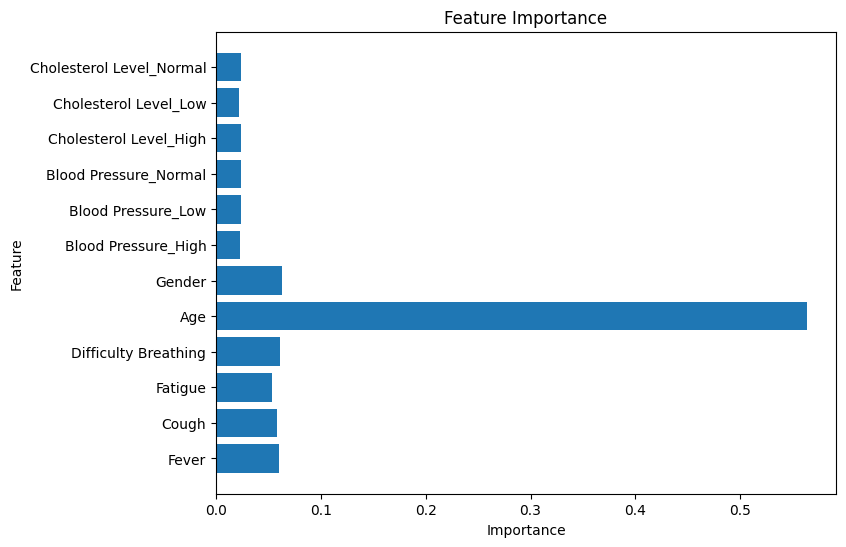

In [962]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
feature_names = X_train.columns
plt.figure(figsize=(8, 6))
plt.barh(feature_names, feature_importances)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.savefig('feature_importance.png')
plt.show()


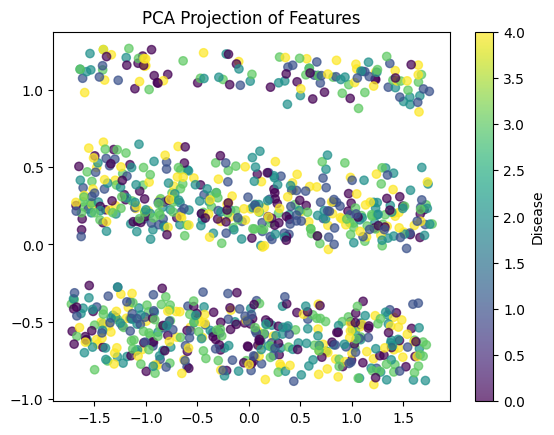

In [963]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X_train)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label='Disease')
plt.title('PCA Projection of Features')
plt.show()


In [964]:
import pandas as pd
import joblib

# Example test sample
test_sample = pd.DataFrame({
    'Fever': ['Yes'],
    'Cough': ['No'],  # Fixed typo from 'Non' to 'No'
    'Fatigue': ['Yes'],
    'Difficulty Breathing': ['No'],
    'Age': [80],
    'Gender': ['Female'],
    'Blood Pressure': ['Normal'],
    'Cholesterol Level': ['High']
})

# Step 1: Load Encoders and Scalers
gender_encoder = joblib.load('gender_encoder.pkl')
disease_encoder = joblib.load('disease_encoder.pkl')
bp_encoder = joblib.load('bp_encoder.pkl')  # One-hot encoder for Blood Pressure
cholesterol_encoder = joblib.load('cholesterol_encoder.pkl')  # One-hot encoder for Cholesterol Level
scaler = joblib.load('scaler.pkl')
print("Disease Encoder Classes:", disease_encoder.classes_)

# Step 2: Preprocess Test Sample
# Encode binary columns
test_sample['Fever'] = test_sample['Fever'].map({'Yes': 1, 'No': 0})
test_sample['Cough'] = test_sample['Cough'].map({'Yes': 1, 'No': 0})
test_sample['Fatigue'] = test_sample['Fatigue'].map({'Yes': 1, 'No': 0})
test_sample['Difficulty Breathing'] = test_sample['Difficulty Breathing'].map({'Yes': 1, 'No': 0})

# Encode 'Gender'
test_sample['Gender'] = gender_encoder.transform(test_sample['Gender'])

# One-hot encode 'Blood Pressure'
bp_encoded = bp_encoder.transform(test_sample[['Blood Pressure']])
bp_columns = bp_encoder.get_feature_names_out(['Blood Pressure'])
bp_df = pd.DataFrame(bp_encoded, columns=bp_columns, index=test_sample.index)

# One-hot encode 'Cholesterol Level'
cholesterol_encoded = cholesterol_encoder.transform(test_sample[['Cholesterol Level']])
cholesterol_columns = cholesterol_encoder.get_feature_names_out(['Cholesterol Level'])
cholesterol_df = pd.DataFrame(cholesterol_encoded, columns=cholesterol_columns, index=test_sample.index)

# Drop original columns and merge encoded DataFrames
test_sample = test_sample.drop(columns=['Blood Pressure', 'Cholesterol Level'])
test_sample = pd.concat([test_sample, bp_df, cholesterol_df], axis=1)

# Scale 'Age'
test_sample['Age'] = scaler.transform(test_sample[['Age']])

# Step 3: Align Test Sample with Training Data Columns
# Ensure test_sample has the same columns as the training data
missing_cols = set(X_labeled.columns) - set(test_sample.columns)
for col in missing_cols:
    test_sample[col] = 0  # Add missing columns with default value

# Ensure the column order matches the training data
test_sample = test_sample[X_labeled.columns]

# Step 4: Predict and Decode
# Predict disease
prediction = model.predict(test_sample)


# Decode numerical prediction back to the original label
decoded_prediction = disease_encoder.inverse_transform([int(prediction[0])])

print("Predicted Disease (Original Name):", decoded_prediction[0])


Disease Encoder Classes: ['Asthma' 'Common Cold' 'Dengue Fever' 'Eczema' 'Influenza']
Predicted Disease (Original Name): Influenza


In [965]:
# Ensure 'Disease' column uses the correct LabelEncoder classes
disease_encoder = joblib.load('disease_encoder.pkl')

# Print the encoder's classes for verification
print("Disease Encoder Classes:", disease_encoder.classes_)

# Predict disease
prediction = model.predict(test_sample)

# Debug the raw prediction
print("Raw Prediction (Encoded):", prediction)

# Convert prediction to integer if it is not already
if isinstance(prediction[0], float):
    prediction = [int(prediction[0])]

# Decode the predicted class
decoded_prediction = disease_encoder.inverse_transform(prediction)

print("Predicted Disease (Original Name):", decoded_prediction[0])


Disease Encoder Classes: ['Asthma' 'Common Cold' 'Dengue Fever' 'Eczema' 'Influenza']
Raw Prediction (Encoded): [4.]
Predicted Disease (Original Name): Influenza


In [966]:
data.to_csv(modified_path, index=False)